In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from fastai import *
from fastai.vision import *
from fastai.vision.gan import *
from ArNet.generators import *
from ArNet.critics import *
from ArNet.dataset import *
from ArNet.loss import *
from ArNet.save import *
from ArNet.fid_loss import *
from ArNet.ssim import *
from ArNet.metrics import *

import torchvision
import geffnet # efficient/ mobile net

In [2]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'

path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'

proj_id = 'unet_superRes_mobilenetV3_LPIPS'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

name_gen = "MobilenetV3_Patch_GEN"
path_gen = path/name_gen

generate_training_img = False

In [3]:
crit_name

'unet_superRes_mobilenetV3_LPIPS_crit'

In [4]:
path/name_gen

PosixPath('dataset/MobilenetV3_Patch_GEN')

In [5]:
def get_crit_data(classes, bs, sz):
    src = ImageList.from_folder(path, include=classes, recurse=True).split_by_rand_pct(0.1)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(), size=sz).databunch(bs=bs, num_workers=4).normalize(imagenet_stats))
    return data

In [6]:
bs = 8
sz = 256

In [7]:
data_crit = get_crit_data([name_gen, "DIV2K_train_HR"], bs=bs, sz=sz)

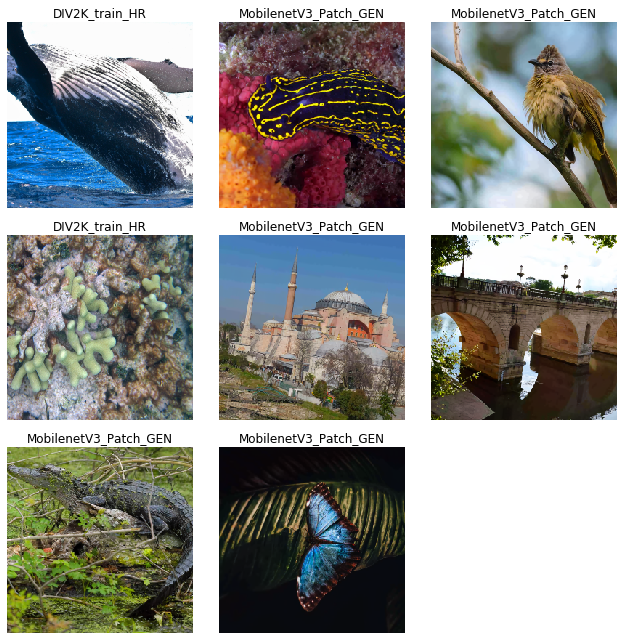

In [8]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [9]:
learn_critic = crit_learner(data=data_crit, nf=64)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


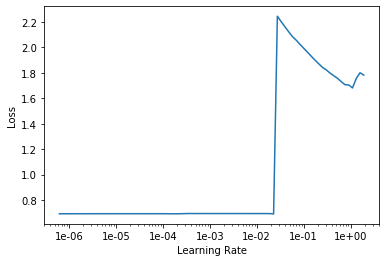

In [10]:
learn_critic.lr_find()
learn_critic.recorder.plot()

In [17]:
learn_critic.fit_one_cycle(3, 1e-5)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.692541,0.691828,0.546494,01:20
1,0.692119,0.691716,0.542627,01:20
2,0.692312,0.691679,0.541966,01:19


In [ ]:
learn_critic.save("/data/students_home/fmameli/repos/Artifact_Removal_GAN/models/" + crit_name + "_0")

In [ ]:
learn_critic.fit_one_cycle(5, 1e-5)

In [ ]:
learn_critic.fit_one_cycle(3, 1e-3)

In [18]:
learn_critic.save("/data/students_home/fmameli/repos/Artifact_Removal_GAN/models/" + crit_name + "_1")

# GAN

In [7]:
learn_crit=None
learn_gen=None
gc.collect()

0

In [8]:
lr=2e-5
sz=512
bs=1

In [9]:
data_crit = get_crit_data([name_gen, 'test'], bs=bs, sz=sz)

learn_crit = crit_learner(data=data_crit, nf=64)

weights = "/data/students_home/fmameli/repos/Artifact_Removal_GAN/models/" + crit_name + "_1"
learn_crit.load(weights, with_opt=False)

Learner(data=ImageDataBunch;

Train: LabelList (810 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
MobilenetV3_Patch_GEN,MobilenetV3_Patch_GEN,MobilenetV3_Patch_GEN,MobilenetV3_Patch_GEN,MobilenetV3_Patch_GEN
Path: dataset;

Valid: LabelList (89 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
MobilenetV3_Patch_GEN,MobilenetV3_Patch_GEN,MobilenetV3_Patch_GEN,MobilenetV3_Patch_GEN,MobilenetV3_Patch_GEN
Path: dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Dropout2d(p=0.075, inplace=False)
  (2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (3): Dropout2d(p=0.15, inplac

In [10]:
# model = geffnet.mobilenetv3_rw
model = geffnet.mobilenetv3_small_minimal_100
loss_func = lpips_loss()

bs=1
sz=512

data_gen = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)

learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=2)

# weights = "/data/students_home/fmameli/repos/Artifact_Removal_GAN/models/unet_wideNf2_mobileV3_DivFlickr1k_P64px_SuperRes_gen_3"
weights = "/data/students_home/fmameli/repos/Artifact_Removal_GAN/models/unet_wideNf2_mobileMin_DivFlickr1k_P64px_SuperRes_gen_3"
learn_gen.load(weights, with_opt=False)

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparable

In [18]:
checkpoint_num = 0

In [19]:
gen_new_checkpoint_name = gen_name + "_GAN_" + str(checkpoint_num)

In [20]:
gen_new_checkpoint_name

'unet_superRes_mobilenetV3_LPIPS_gen_GAN_0'

In [22]:
# switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.52)
switcher = partial(FixedGANSwitcher, n_crit=5, n_gen=2)
learn_gan = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.0,1.5), show_img=True, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.9)), wd=1e-3)
learn_gan.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
learn_gan.callback_fns.append(partial(GANSaveCallback, learn_gen=learn_gen, filename=gen_new_checkpoint_name, save_iters=100))

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,0.840820,0.826113,1.239586,0.693233,07:43


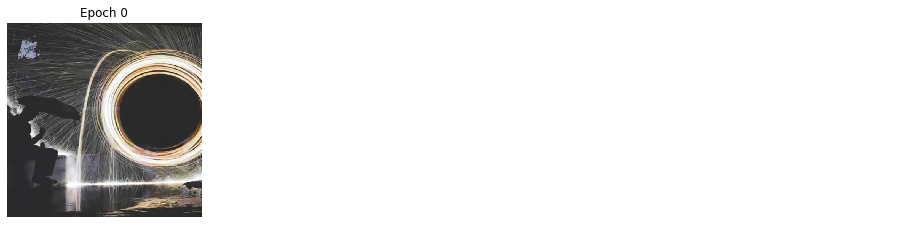

In [23]:
learn_gan.data = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=1, sz=sz)
learn_gen.freeze_to(-1)
learn_gan.fit(1, 1e-5)

In [ ]:
learn_gan.data = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)
learn_gen.unfreeze()
learn_gan.fit(1, 1e-5)

# Validation

In [14]:
learn_gen.metrics.append(SSIM_Metric_gen())
learn_gen.metrics.append(SSIM_Metric_input())
learn_gen.metrics.append(LPIPS_Metric_gen())
learn_gen.metrics.append(BRISQUE_Metric_gen())
learn_gen.metrics.append(BRISQUE_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_target())
learn_gen.metrics.append(NIQE_Metric_gen())
learn_gen.metrics.append(NIQE_Metric_input())
learn_gen.metrics.append(NIQE_Metric_target())

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [24]:
val = learn_gen.validate()

In [25]:
print("Gen loss " + str(val[0]))

Gen loss 0.39908078


In [26]:
for name, m in zip(learn_gen.metrics, val[1:]):
    if isinstance(m, torch.Tensor):
        print(name, m.item())
    else:
        print(name, m)

SSIM_Metric_gen 0.6781505942344666
SSIM_Metric_input 0.7075174450874329
LPIPS_Metric_gen 0.19000093638896942
BRISQUE_Metric_gen 84.62826264497369
BRISQUE_Metric_input 87.3549426119021
BRISQUE_Metric_target 85.32215693738695
NIQE_Metric_gen 17.084023
NIQE_Metric_input 17.860744
NIQE_Metric_target 15.693551


In [ ]:
learn_gen.metrics

In [ ]:
gc.collect()

In [ ]:
save_name = "unet_wideNf2_mobilenetV3_GAN_Flickr_1"
learn_gen.save("/data/students_home/fmameli/repos/Artifact_Removal_GAN/models/" + save_name)

# Test gen

In [ ]:
bs=1
sz=512

path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'
size=( 512, 680)

In [ ]:
data_1k = (ImageImageList.from_folder(path_lowRes_512, presort=True).split_by_idxs(
            train_idx=list(range(0, 800)), valid_idx=list(range(800, 900)))
          .label_from_func(lambda x: path_fullRes/x.name.replace(".jpg", ".png"))
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))

In [ ]:
learn_gen.data = data_1k
learn_gen.freeze()
gc.collect()

In [28]:
img_index = 2

torch.Size([3, 512, 680])


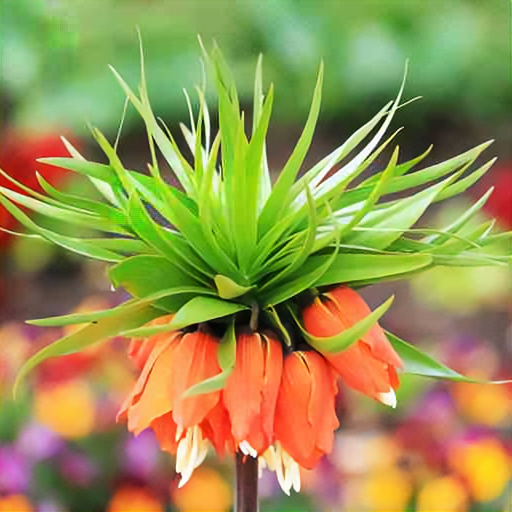

In [29]:
fn = data_gen.valid_dl.x.items[img_index]; fn

img = open_image(fn); print(img.shape)
p,img_hr,b = learn_gen.predict(img)

img_index += 1
p

In [ ]:
img